
# 📊 Cryptocurrency Price Trends: Forecasting the Future of Digital Assets



This project focuses on analyzing and forecasting the price trends of **Bitcoin (BTC-USD)** using deep learning techniques, particularly **LSTM (Long Short-Term Memory)** networks. We use historical data to visualize trends, train a predictive model, and forecast future prices.


In [1]:

!pip install yfinance torch pandas numpy matplotlib scikit-learn --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.7 MB/s eta 0:00:00


## 📥 Step 1: Download Historical Data

In [2]:

import yfinance as yf
import pandas as pd

# Download Bitcoin data
df = yf.download("BTC-USD", start="2020-01-01", end="2024-12-31", interval="1d")
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace=True)
df.to_csv("bitcoin_price.csv")
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,19725074095


## 📊 Step 2: Exploratory Data Analysis (EDA)

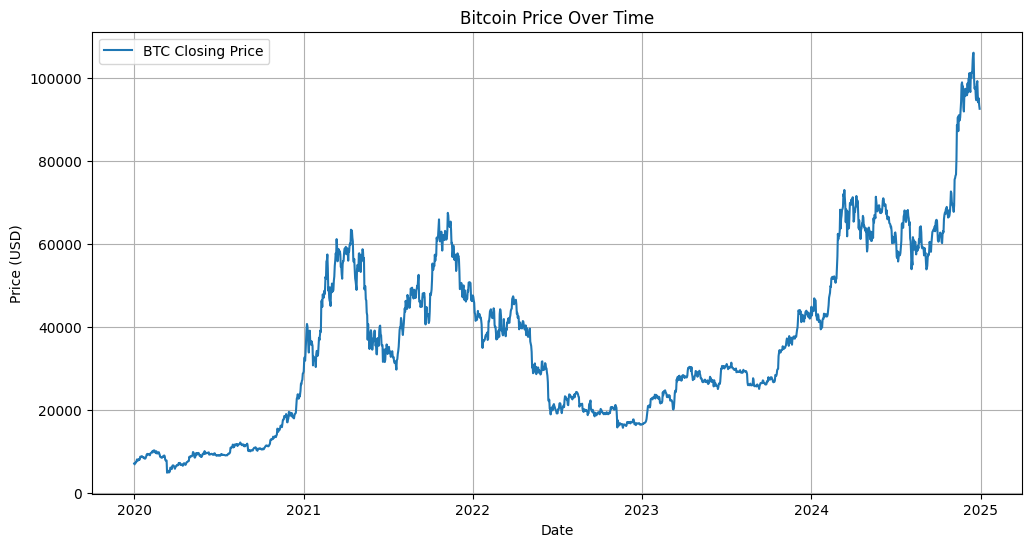

In [3]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='BTC Closing Price')
plt.title("Bitcoin Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()


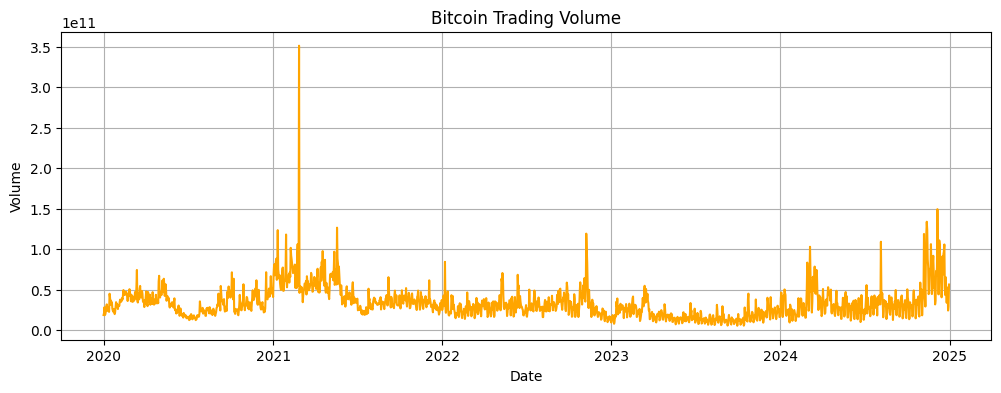

In [4]:

# Plot Volume
plt.figure(figsize=(12, 4))
plt.plot(df['Volume'], color='orange')
plt.title("Bitcoin Trading Volume")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid()
plt.show()


## 🧹 Step 3: Data Preprocessing

In [5]:

from sklearn.preprocessing import MinMaxScaler
import numpy as np

close_prices = df[['Close']].values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices)

# Sequence creation
sequence_length = 60
X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length])

X = np.array(X)
y = np.array(y)

X.shape, y.shape


((1766, 60, 1), (1766, 1))

In [6]:

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (1412, 60, 1), Test size: (354, 60, 1)


## 🧠 Step 4: Building and Training LSTM Model

In [7]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Prepare data
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

# LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 50)
        c0 = torch.zeros(2, x.size(0), 50)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

model = LSTMModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:

for epoch in range(10):
    for xb, yb in train_loader:
        preds = model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/10, Loss: {loss.item():.6f}")


Epoch 1/10, Loss: 0.035452
Epoch 2/10, Loss: 0.011237
Epoch 3/10, Loss: 0.000273
Epoch 4/10, Loss: 0.000253
Epoch 5/10, Loss: 0.000758
Epoch 6/10, Loss: 0.000497
Epoch 7/10, Loss: 0.000148
Epoch 8/10, Loss: 0.000099
Epoch 9/10, Loss: 0.002169
Epoch 10/10, Loss: 0.000194


## 📈 Step 5: Model Evaluation & Prediction

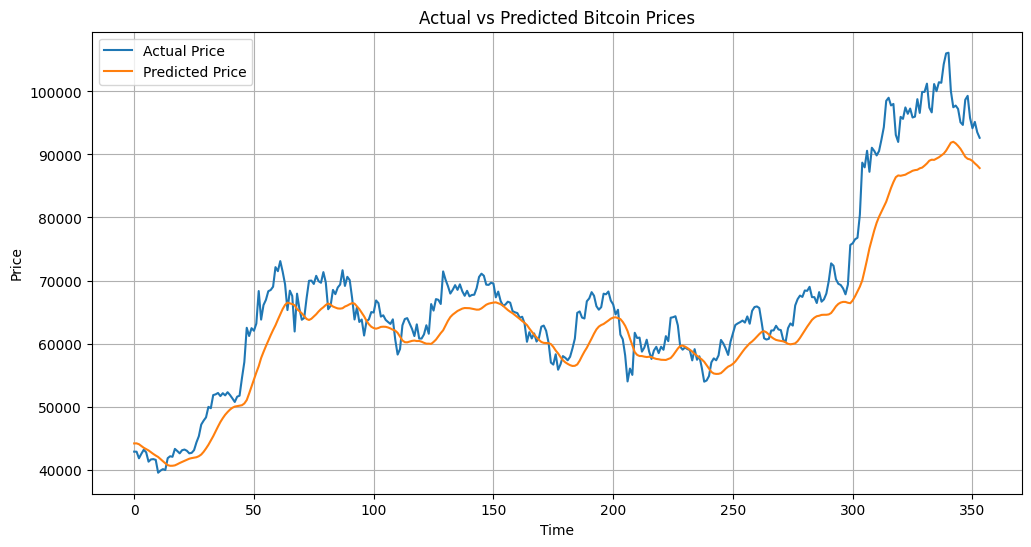

In [9]:

model.eval()
with torch.no_grad():
    test_preds = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

# Rescale predictions and actual values
predicted_prices = scaler.inverse_transform(test_preds)
actual_prices = scaler.inverse_transform(y_test)

# Plot
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title("Actual vs Predicted Bitcoin Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


## 🔮 Step 6: Forecasting Future Prices

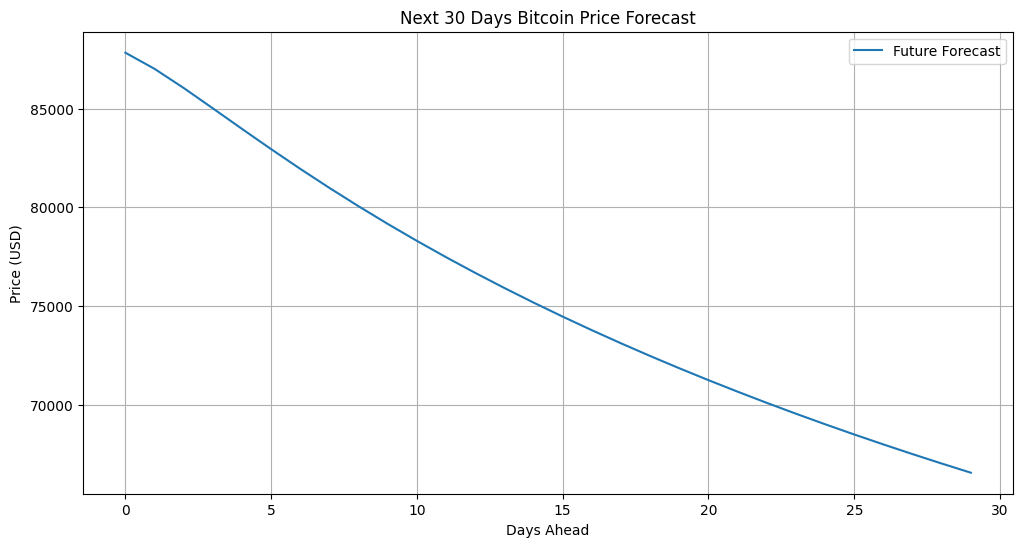

In [10]:

# Forecast next 30 days
future_input = X_test[-1]
future_preds = []

for _ in range(30):
    with torch.no_grad():
        next_pred = model(torch.tensor(future_input[np.newaxis, :, :], dtype=torch.float32)).numpy()
    future_preds.append(next_pred[0, 0])
    future_input = np.append(future_input[1:], [[next_pred[0, 0]]], axis=0)

# Rescale
future_prices = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(future_prices, label='Future Forecast')
plt.title("Next 30 Days Bitcoin Price Forecast")
plt.xlabel("Days Ahead")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()


## ✅ Summary
- We visualized Bitcoin's historical price trends.
- Built and trained an LSTM model to forecast future prices.
- Forecasted the next 30 days based on the learned patterns.

You can extend this project by adding other cryptocurrencies or technical indicators.